In [1]:
import scipy
from scipy.cluster import vq
from scipy.misc import imread
from PIL import Image
import os
import sys
import joblib
import copy
import cv2
from glob import glob
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cross_validation import KFold

from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras import __version__ as keras_version
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


C:\Users\archi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
try:
    img_path_list = glob("train_split/*/*")
    if not len(img_path_list)==3019:
        
        train_split = os.mkdir("train_split")
        val_split = os.mkdir("val_split")
        
        classes = os.listdir("train/")

        for fish_species in classes:
            os.mkdir("train_split/"+fish_species)
            os.mkdir("val_split/"+fish_species)

        for species in classes: 
            fish_root_list = os.listdir('train/'+species+'/')
            split_index = int(0.8*len(fish_root_list))
            np.random.shuffle(fish_root_list)
            train_list = fish_root_list[:split_index]
            valid_list = fish_root_list[split_index:]
            for image in train_list :
                shutil.copy('train/'+species+'/' + image,"train_split/" + species + '/' + image)
            for image in valid_list:
                shutil.copy('train/'+species+'/' + image,"val_split/" + species + '/' + image)
except:
    pass



In [3]:
path, classes = os.getcwd() + '\\' + 'train\\', ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
count_dict, different_file_sizes = {}, {}
X_train, X_train_id, y_train = [], [], []
figs=[]

#resizing images to 224x224 for uniformity
get_im_cv2 = lambda path: cv2.resize(cv2.imread(path), (32, 32), cv2.INTER_LINEAR)

def create_train_data(file,index):
    X_train.append(get_im_cv2(file))
    X_train_id.append(file)
    y_train.append(index)
    
for fish_species in classes:
    i=1
    idx = classes.index(fish_species)
    g = glob(path + fish_species + '\\' + '*.jpg')
    count_dict[fish_species] = len(g)
    for img_file in g:
        if i==1: figs.append((fish_species,imread(img_file)))
        i=0
        size = "_".join(map(str,list(imread(img_file).shape)))
        different_file_sizes[size] = different_file_sizes.get(size,0) + 1
        create_train_data(img_file,idx)

orig_X_train = copy.deepcopy(X_train)
orig_train_id = copy.deepcopy(X_train_id)
orig_train_target = copy.deepcopy(y_train)

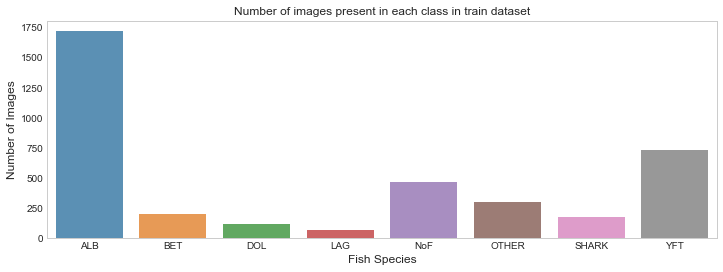

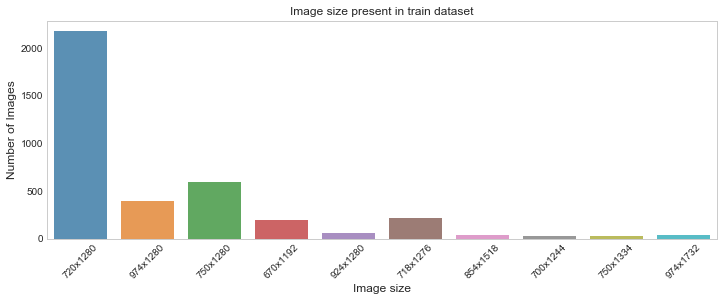

Displaying how each species of fish looks like


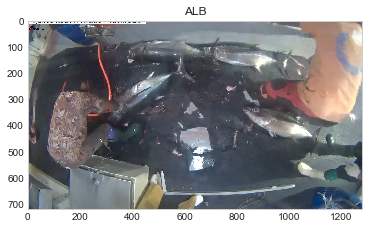

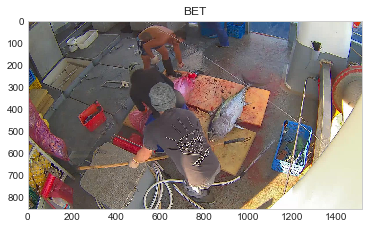

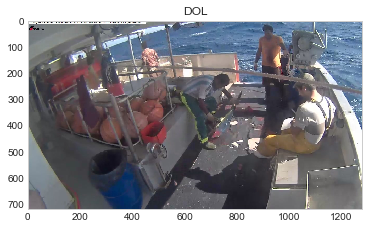

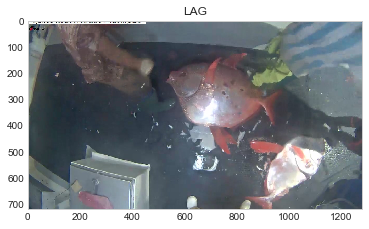

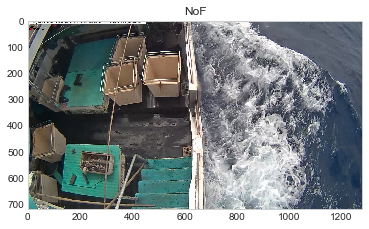

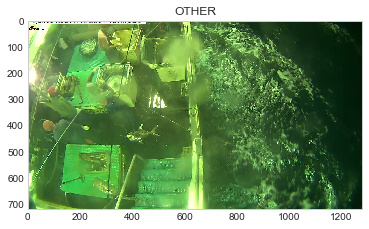

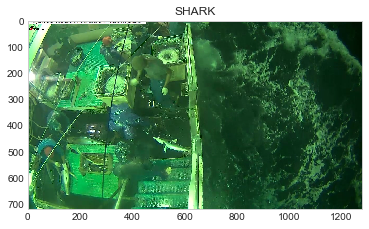

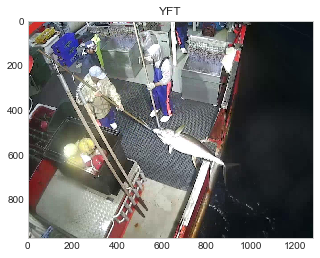

In [4]:
#checking class imbalance    
plt.figure(figsize=(12,4))
sns.barplot(list(count_dict.keys()), list(count_dict.values()), alpha=0.8)
plt.xlabel('Fish Species', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Number of images present in each class in train dataset")
plt.show()

#checking for different file sizes in data
plt.figure(figsize=(12,4))
cleaned_size=[str(key.split("_")[0])+"x"+str(key.split("_")[1]) for key in list(different_file_sizes.keys())]
sns.barplot(cleaned_size, list(different_file_sizes.values()), alpha=0.8)
plt.xlabel('Image size', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title("Image size present in train dataset")
plt.xticks(rotation=45)
plt.show()

#Displaying how each species of fish looks like
print("Displaying how each species of fish looks like")
for fig in figs:
    plt.title(fig[0])
    plt.imshow(fig[1])
    plt.show()
    


In [ ]:
img_path_list = glob("train/*/*")
train_target = copy.deepcopy(orig_train_target)
labels = LabelEncoder().fit_transform(train_target)

def fit_and_predict(features, labels, model):
    X_train,X_val,y_train,y_val = train_test_split(features,labels,test_size = 0.25, random_state = 42)
    model.fit(X_train,y_train)
    preds_validation = model.predict(X_val)
    preds_validation_proba = model.predict_proba(X_val)
    print("Predictions on validation set")
    print("Accuracy score on Validation set is: ", accuracy_score(y_val,preds_validation))
    print("F1 score on Validation set is: ", f1_score(y_val,preds_validation,average="weighted"))
    print("Log loss score on Validation set is: ", log_loss(y_val,preds_validation_proba))
    

In [ ]:
def knn_model(orig_train_target, labels, img_path_list):

    # Get the color histograms from the images

    features = []
    for img_path in img_path_list:
        hist = cv2.calcHist([cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2HSV)],[0,1,2],None,(8,8,8),[0,256,0,256,0,256])
        cv2.normalize(hist,hist)
        features+=hist.flatten(),


    model = KNeighborsClassifier(n_neighbors = 2, n_jobs = -1)
    fit_and_predict(features, labels, model)

knn_model(orig_train_target, labels, img_path_list)

In [ ]:
def naive_bayes_and_svm_model(img_path_list, labels):
    
    CLASSES = {
        'ALB': 1,
        'BET': 2,
        'DOL': 3,
        'LAG': 4,
        'NoF': 5,
        'OTHER': 6,
        'SHARK': 7,
        'YFT': 8
    }

    des_list = [(f, np.float32(cv2.ORB_create().detectAndCompute(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB), None)[1])) for f in img_path_list]


    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))

    print("\nClustering the descriptors to form BOVW dictionary..\n")

    im_features = np.zeros((len(img_path_list), 3), "float32")
    for i in range(len(img_path_list)):
        words, distance = vq.vq(des_list[i][1], cv2.kmeans(descriptors, 3, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)[2])
        for w in words:
            im_features[i][w] += 1

    # Scaling the values of features
    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)
    
    model1, model2 = GaussianNB(), svm.SVC(kernel='rbf', C = 1.0, probability=True)
    fit_and_predict(im_features, labels, model1)
    fit_and_predict(im_features, labels, model2)


naive_bayes_and_svm_model(img_path_list, labels)

In [ ]:
def basic_cnn_model():
    # it's just typical structure based on other good known convolutional NN structures like VGG16 and also examples from Keras. 
# Parameters like convolution size 3x3 and pooling 2x2 are widely used in image processing. 
# CNN has low number of layers and low number of filters (like 4 and 8) because code run without GPU.
#https://www.kaggle.com/zfturbo/fishy-keras-lb-1-25267/comments



    def create_model():
        model = Sequential()
        model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(8, activation='softmax'))

#         model = Sequential()
#         model.add(ZeroPadding2D((1, 1), input_shape=(3, 32, 32), dim_ordering='th'))
#         model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th'))
#         model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
#         model.add(Convolution2D(4, 3, 3, activation='relu', dim_ordering='th'))
#         model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))

#         model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
#         model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
#         model.add(ZeroPadding2D((1, 1), dim_ordering='th'))
#         model.add(Convolution2D(8, 3, 3, activation='relu', dim_ordering='th'))
#         model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), dim_ordering='th'))

#         model.add(Flatten())
#         model.add(Dense(32, activation='relu'))
#         model.add(Dropout(0.5))
#         model.add(Dense(32, activation='relu'))
#         model.add(Dropout(0.5))
#         model.add(Dense(8, activation='softmax'))

        
        model.compile(optimizer='adam', loss='categorical_crossentropy')

        return model



    def run_cross_validation_create_models(train_data, train_target, train_id, nfolds=10):
 
        num_fold, sum_score = 0, 0

        for train_idx, test_idx in KFold(len(train_id), n_folds=nfolds, shuffle=True, random_state=51):
            model = create_model()
            X_train, Y_train, X_valid, Y_valid = train_data[train_idx], train_target[train_idx], train_data[test_idx], train_target[test_idx]

            num_fold += 1
            print('Start KFold number {} from {}'.format(num_fold, nfolds))
            print('Split train: ', len(X_train), len(Y_train))
            print('Split valid: ', len(X_valid), len(Y_valid))

            model.fit(X_train, Y_train, batch_size=16, nb_epoch=30,
                  shuffle=True, verbose=2, validation_data=(X_valid, Y_valid),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0),])

            score = log_loss(Y_valid, model.predict(X_valid.astype('float32'), batch_size=16, verbose=2))
            print('Score log_loss: ', score)
            sum_score += score*len(test_idx)


        print("Log_loss train independent avg: ", sum_score/len(train_data))



    train_data = copy.deepcopy(orig_X_train)
    train_id = copy.deepcopy(orig_train_id)
    train_target = copy.deepcopy(orig_train_target)

    train_target = np_utils.to_categorical(np.array(train_target, dtype=np.uint8), 8)

    train_data = np.array(train_data, dtype=np.uint8).transpose((0, 3, 1, 2)).astype('float32')/255

    run_cross_validation_create_models(train_data, train_target, train_id)

basic_cnn_model(orig_X_train, orig_train_id, orig_train_target)

In [ ]:
def data_augmentation():
    # The directories where the images are located

    fish_classes, X_train, train_target = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'], [], []

    for fish in fish_classes:
        tmp = [fish+'/'+im for im in os.listdir('train/'+'{}'.format(fish))]
        X_train.extend(tmp)
        train_target.extend(np.tile(fish, len(tmp)))
        print("{0} photos of {1}".format(len(tmp), fish))


    # Process all of the training images
    train = np.ndarray((len(X_train), 256, 256, 3), dtype=np.uint8)

    for i,img in enumerate(X_train): 
        train[i] = cv2.resize(cv2.imread('train/'+img, cv2.IMREAD_COLOR), (256,256), interpolation=cv2.INTER_CUBIC)

    print(train.shape)


    # One Hot Encoding Labels
    train_target = np_utils.to_categorical(LabelEncoder().fit_transform(np.array(train_target)))

    # Normalize the pixel values
    train = train.astype('float32') / 255


    def cnn_model():
        model = Sequential()
        model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(256, 256, 3)))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(8, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model



    # Transform the images to prevent overfitting.
    datagen = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

    # Split the data into the number of folds (nFolds)
    num_fold, sum_score, hist = 0, 0, [] # Keeps track of the current fold
    # Keeps track of the total score/log loss
    # Contains the model for each of the folds
    best_model = cnn_model()
    checkpointer = ModelCheckpoint(filepath='basic_cnn_model_dataaugmentation_weights.hdf5', verbose=1, save_best_only=True)
    for train_idx, test_idx in KFold(len(X_all), n_folds=5, shuffle=True, random_state=2):
        model = cnn_model()
        x_train, y_train, x_valid, y_valid = train[train_idx], train_target[train_idx], train[test_idx], train_target[test_idx]
        datagen.fit(x_train)

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, 5))
        print('Split train:', len(x_train), len(y_train))
        print('Split valid:', len(x_valid), len(y_valid))

        # Use EarlyStopping to stop the training when the learning plateaus.

        # Transform data and train the model
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 32),
                            samples_per_epoch=len(x_train), nb_epoch = 5, 
                            verbose = 2, validation_data = (x_valid, y_valid),
                            callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto'), checkpointer])

        # Make the predictions
        predictions_valid = model.predict(x_valid, verbose=1)

        # Record and sum score/log loss
        score = log_loss(y_valid, predictions_valid)
        print('Score log_loss: ', score)
        sum_score += score

        # Store valid predictions
        for i in range(len(test_index)):
            y_all[test_index[i]] = predictions_valid[i]

        hist.append(history)

    # Average the validation scores from all of the folds.
    score = sum_score/num_fold
    print("Log_loss avg: ", score)
    info_string = 'loss_' + str(score) + '_folds_' + str(nFolds) + '_ep_' + str(nb_epoch)
    
    best_model.load_weights("basic_cnn_model_dataaugmentation_weights.hdf5")
    best_model.summary()
    test_files = glob('test_stg1/*')
    test_files.extend(glob('test_stg2/*'))
    test_file_names = [im for im in os.listdir('test_stg1/')]
    test_file_names.extend(glob('test_stg2/*'))
    test_data=[]
    for each_file in test_files:
        test_data.append(cv2.resize(cv2.imread(each_file), (256, 256), cv2.INTER_LINEAR))

    preds = best_model.predict_proba(test_data)
    clipped_preds = np.clip(preds,(1-0.82)/7,0.82)
    submission = pd.DataFrame(clipped_preds, columns= os.listdir("train/"))
    submission.insert(0, 'image', test_file_names)
    submission.head()
    submission.to_csv("basic_cnn_model_dataaugmentation_submission.csv",index = False)
    
data_augmentation()

1719 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT
(3777, 256, 256, 3)


In [ ]:
def plot_graphs(history):    
    # summarize history for accuracy
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
    plt.title('model accuracy'); plt.ylabel('accuracy');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss');
    plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
    plt.show()

In [ ]:
comvert_img = lambda i: return preprocess_input(np.expand_dims(image.img_to_array(image.load_img(i, target_size = (150, 150))), axis = 0))

np.save("train_set.npy",np.vstack([convert_img(i) for i in glob("train_split/*/*")]))
np.save("valid_set.npy",np.vstack(convert_img(i) for i in glob("val_split/*/*"))
train_img_features, valid_img_features = np.load('train_set.npy'), np.load('valid_set.npy')

# Get the labels

train_target_labels, valid_target_labels = [], []
for fish_species in os.listdir("train_split/"):
    train_target_labels.extend([fish_species]*len(os.listdir("train_split/"+fish_species+'/')))
    valid_target_labels.extend([fish_species]*len(os.listdir("val_split/"+fish_species+'/')))

encoded_train, encoded_valid = to_categorical(LabelEncoder().fit_transform(train_target_labels)), to_categorical(LabelEncoder().fit_transform(valid_target_labels))



In [ ]:
def data_augmentation_vgg16_model(train_img_features, encoded_train, valid_img_features, encoded_valid):
    vgg16_base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(150, 150,3))

    print('Adding new layers...')
    output = vgg16_base_model.get_layer(index = -1).output  
    output = Flatten()(output)
    # let's add a fully-connected layer
    output = Dense(4096,activation = "relu")(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(512,activation = "relu")(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    # and a logistic layer -- let's say we have 200 classes
    output = Dense(8, activation='softmax')(output)


    model = Model(vgg16_base_model.input, output)

    for l in model.layers[:19]:
        l.trainable = False

    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])
    model.summary()

    train_img_datagen = ImageDataGenerator(shear_range=0.1, zoom_range=0.1, rotation_range=10., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    
    val_img_datagen = ImageDataGenerator()
    history = model.fit_generator(train_img_datagen.flow(train_img_features, encoded_train, batch_size=10), nb_epoch=5,samples_per_epoch = 3019,                     
                  validation_data=val_img_datagen.flow(valid_img_features, encoded_valid ,batch_size=10,shuffle=False),
                nb_val_samples=758,callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto'),ModelCheckpoint("data_augmented_weights.h5", monitor='val_acc', verbose = 1, save_best_only = True)])

    model.load_weights("data_augmented_weights.h5")
    
    plot_graphs(history)

data_augmentation_vgg16_model(train_img_features, encoded_train, valid_img_features, encoded_valid)

In [ ]:
def fully_connected_cnn_batchNorm(train_img_features, encoded_train, valid_img_features, encoded_valid):
    model = Sequential()
    model.add(Flatten(input_shape=train_img_features.shape[1:]))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])

    history = model.fit(train_img_features, encoded_train, batch_size=10, nb_epoch=5,
              validation_data=(valid_img_features,encoded_valid),shuffle=True,callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto'),ModelCheckpoint("batch_normalized_weights.h5", monitor='val_acc', verbose = 1, save_best_only = True)])

    model.load_weights("batch_normalized_weights.h5")

    plot_graphs(history)
    
fully_connected_cnn_batchNorm(train_img_features, encoded_train, valid_img_features, encoded_valid)

In [ ]:
def fully_connected_cnn_batchNormDropout(train_img_features, encoded_train, valid_img_features, encoded_valid):

    model = Sequential()
    model.add(Flatten(input_shape=train_features.shape[1:]))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='softmax'))


    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])



    history = model.fit(train_img_features, encoded_train, batch_size=10, nb_epoch=5,
                  validation_data=(valid_img_features, encoded_valid),shuffle=True,callbacks = [EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='auto'),ModelCheckpoint("fully_connected_dropout_weights.h5", monitor='val_acc', verbose = 1, save_best_only = True)])

    model.load_weights("fully_connected_dropout_weights.h5")
    
    plot_graphs(history)
    
fully_connected_cnn_batchNormDropout(train_img_features, encoded_train, valid_img_features, encoded_valid)